In [1]:
import json

task_id = "test"  # Replace with your actual task_id
file_path = f'static/results/{task_id}/video_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)

In [2]:
for video in data:
    print("##", video['video_id'])
    cur_steps = [*video['steps']]
    cur_subgoals = [*video['subgoals']]

    cur_subgoals = sorted(cur_subgoals, key=lambda x: x['start'])
    print("### Subgoals:")
    for subgoal in cur_subgoals:
        print("`", subgoal["title"], "`", end=" --> ")
    print()
    for step in cur_steps:
        print('-', step)
        # for subgoal in cur_subgoals:
        #     if step in subgoal['original_steps']:
        #         print('  -', subgoal['title'])
        print()

## 75p4UHRIMcU
### Subgoals:
`  ` --> ` Prepare Bacon ` --> ` Prepare Cheese and Eggs ` --> ` Cook Spaghetti ` --> ` Prepare Bacon ` --> ` Mix Egg Mixture ` --> ` Combine Ingredients ` --> ` Reserve Pasta Water ` --> ` Combine Ingredients ` --> ` Garnish and Serve ` --> 
- Chop bacon into small pieces.

- Cook the bacon in a pan until crispy, then turn off the heat and let it cool slightly.

- Separate egg yolks from egg whites and place the yolks in a bowl.

- Grate pecorino romano cheese and add it to the egg yolks.

- Add freshly ground black pepper to the egg yolk and cheese mixture.

- Boil water in a pot, add salt, and cook spaghetti until al dente.

- Reserve some pasta water before draining the spaghetti.

- Add a small amount of pasta water to the egg yolk and cheese mixture to help melt the cheese.

- Transfer the cooked spaghetti directly from the pot to the pan with bacon.

- Mix the spaghetti with the bacon and then add the egg yolk mixture, stirring quickly to create a cr

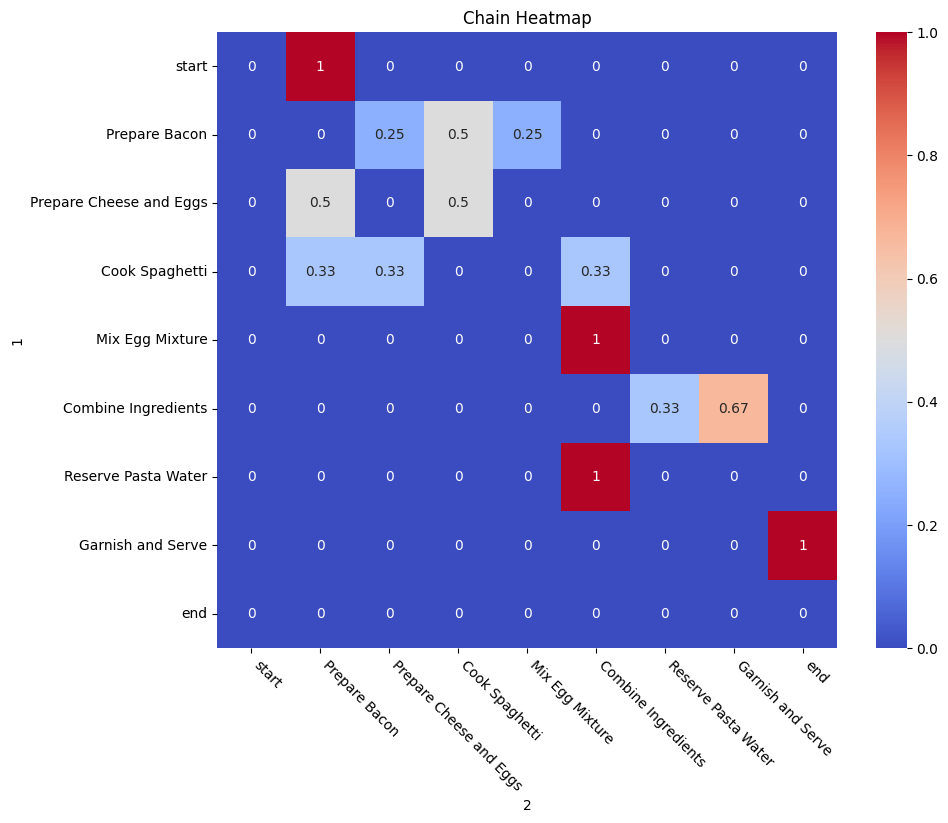

In [4]:
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

def draw_similarity_heatmap(steps_0, steps_1):
    # Load pre-trained model
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

    # Compute embeddings
    embeddings_video_0 = model.encode(steps_0, convert_to_tensor=True).cpu()
    embeddings_video_1 = model.encode(steps_1, convert_to_tensor=True).cpu()

    # Compute cosine similarity matrix
    cosine_sim_matrix = util.pytorch_cos_sim(embeddings_video_0, embeddings_video_1).numpy()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_sim_matrix, annot=True, xticklabels=steps_1, yticklabels=steps_0, cmap='coolwarm')
    # Tilt x-axis labels
    plt.xticks(rotation=-45, ha='left')

    plt.xlabel('Steps Video 1')
    plt.ylabel('Steps Video 0')
    plt.title('Semantic Similarity Heatmap')
    plt.show()

def draw_chain_heatmap(step_sets):
    chain_count = {}
    nexts_count = {}
    for steps in step_sets:
        prev = 'start'
        for step in [*steps, 'end']:
            if prev not in chain_count:
                chain_count[prev] = {}
            if step not in chain_count[prev]:
                chain_count[prev][step] = 0
            chain_count[prev][step] += 1

            if prev not in nexts_count:
                nexts_count[prev] = 0
            nexts_count[prev] += 1
            prev = step
    
    keys = [*chain_count.keys(), 'end']

    chain_matrix = np.zeros((len(keys), len(keys)))
    for i, key in enumerate(keys):
        for j, key2 in enumerate(keys):
            if key in chain_count and key2 in chain_count[key]:
                chain_matrix[i, j] = chain_count[key][key2] / nexts_count[key]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(chain_matrix, annot=True, xticklabels=keys, yticklabels=keys, cmap='coolwarm')
    # Tilt x-axis labels
    plt.xticks(rotation=-45, ha='left')

    plt.xlabel('2')
    plt.ylabel('1')
    plt.title('Chain Heatmap')
    

combines = {
    # 'Prepare Meat': 'Prepare and Cook Meat',
    # 'Cook Meat': 'Prepare and Cook Meat',
    # 'Mix Egg and Cheese': 'Combine Ingredients',
    # 'Combine Pasta and Meat': 'Combine Ingredients',
    # 'Add Egg Mixture': 'Combine Ingredients',
}

step_sets = []
for video in data:
    cur_subgoals = [*video['subgoals']]
    cur_subgoals = sorted(cur_subgoals, key=lambda x: x['start'])
    steps = []
    for subgoal in cur_subgoals:
        if subgoal["title"] != '':
            if subgoal["title"] in combines:
                steps.append(combines[subgoal["title"]])
            else:
                steps.append(subgoal["title"])
    combined_steps = []
    for step in steps:
        if len(combined_steps) > 0 and combined_steps[-1] == step:
            continue
        combined_steps.append(step)
    step_sets.append(combined_steps)

draw_chain_heatmap(step_sets)


In [4]:
import json

task_id = "test-v2"
alignment_file_path = f'static/results/{task_id}/alignment_sets.json'

with open(alignment_file_path, 'r') as file:
    alignment_data = json.load(file)

In [5]:
pair_comparisons = {}
for approach, alignment_sets in alignment_data.items():
    for alignment_set in alignment_sets:
        video_id = alignment_set['video_id']
        alignments = alignment_set['alignments']
        for alignment in alignments:
            other_video_id = alignment['other_video_id']
            key = video_id + '-' + other_video_id
            if approach.endswith('baseline_1'):
                key = other_video_id + '-' + video_id
            if key not in pair_comparisons:
                pair_comparisons[key] = {}
            if approach not in pair_comparisons[key]:
                pair_comparisons[key][approach] = []
            pair_comparisons[key][approach].append(alignment)


"""
Output alignments from each approach side-by-side (left & right) for each comparison
"""
for key, comparisons in pair_comparisons.items():
    print("##", key)
    print()
    approaches = [*comparisons.keys()]
    print("|", end="")
    for approach in approaches:
        print(approach, "|", end="")
    print()
    print("|", end="")
    for approach in approaches:
        print("---|", end="")
    print()
    max_alignments = max([len(comparisons[approach]) for approach in approaches if approach in comparisons])
    for i in range(max_alignments):
        print("|", end="")
        for approach in approaches:
            if approach in comparisons:
                if i < len(comparisons[approach]):
                    alignment = comparisons[approach][i]
                    alignment_str = "- ({subgoal_title}) **{relation}** **{aspect}**: {alignment_description}".format(**alignment)
                    print(alignment_str, "|", end="")
                else:
                    print(" |", end="")
            else:
                print(" |", end="")
        print()
    print()
    print()
        

## 75p4UHRIMcU-dzyXBU3dIys

|v1_approach_1 |v1_baseline_1 |v2_approach_1 |v2_baseline_1 |v3_approach_1 |v3_baseline_1 |
|---|---|---|---|---|---|
|- (Combine Ingredients) **alternative** **materials**: The video mentions using either pecorino or parmesan cheese. |- ($meta$) **alternative** **materials**: The video humorously insists on using guanciale instead of bacon, highlighting it as a traditional ingredient for carbonara. |- (Prepare Bacon) **alternative** **tools**: A knife is used to chop the bacon before cooking. |- ($meta$) **alternative** **materials**: The video humorously points out that using bacon instead of guanciale means it's not a traditional carbonara. |- (Prepare Bacon) **alternative** **tools**: The video uses a knife to chop the bacon into pieces before cooking. |- ($meta$) **alternative** **materials**: The video emphasizes using only egg yolks for the carbonara sauce, contrasting with the use of whole eggs. |
|- (Combine Ingredients) **alternative** **instructio